In [108]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Other Libraries
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import confusion_matrix
 
# Classifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

Using TensorFlow backend.
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [ ]:
train_identity_data = pd.read_csv('kaggle_datasets/train_identity.csv')
train_transaction_data = pd.read_csv('kaggle_datasets/train_transaction.csv')

In [ ]:
pd.set_option('display.max_columns', 500)
train_transaction_data.head(10)

In [ ]:
train_identity_data.head(10)

In [ ]:
# https://www.kaggle.com/fchmiel/day-and-time-powerful-predictive-feature
train_transaction_data['Transaction_dow'] = np.floor((train_transaction_data['TransactionDT'] / (3600 * 24) - 1) % 7)
train_transaction_data['Transaction_hour'] = np.floor(train_transaction_data['TransactionDT'] / 3600) % 24

In [ ]:
na_columns = train_identity_data.isna().sum()
print(na_columns[na_columns==0])

In [ ]:
pd.set_option('display.max_rows', 500)
na_columns = train_transaction_data.isna().sum()
print(na_columns[na_columns==0])
print(na_columns[na_columns>0]/train_transaction_data.shape[0])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(train_identity_data['id_01'])

In [ ]:
transaction_data_columns = train_transaction_data.columns
numericCols = train_transaction_data._get_numeric_data().columns
categoricalCols = list(set(transaction_data_columns) - set(numericCols))
print('The categorical columns in transaction data are: ',categoricalCols)

In [ ]:
train_transaction_data[categoricalCols] = train_transaction_data[categoricalCols].replace({ np.nan:'missing'})
train_transaction_data[numericCols] = train_transaction_data[numericCols].replace({ np.nan:-1})

In [ ]:
train_transaction_data.head(10)

In [ ]:
sns.countplot(train_transaction_data['isFraud'])

In [ ]:
sns.countplot(train_transaction_data['card6'])

In [ ]:
cardTypes = ['credit','debit','debit or credit','charge card']
for i,i_card in enumerate(cardTypes):
    cardData = eval('train_transaction_data.loc[train_transaction_data["card6"]=="'+i_card+'"]')
    plt.figure(i)
    sns.countplot(cardData['isFraud']).set_title(i_card)

In [ ]:
sns.countplot(train_transaction_data['card4'])

In [ ]:
print('The average transaction amount for non fraudulent transactions is: ', 
      np.mean(train_transaction_data.loc[train_transaction_data["isFraud"]==0]['TransactionAmt']))
print('The average transaction amount for fraudulent transactions is: ', 
      np.mean(train_transaction_data.loc[train_transaction_data["isFraud"]==1]['TransactionAmt']))

In [68]:
print('The Maximum transaction amount for non fraudulent transactions is: ', 
      np.max(train_transaction_data.loc[train_transaction_data["isFraud"]==0]['TransactionAmt']))
print('The Maximum transaction amount for fraudulent transactions is: ', 
      np.max(train_transaction_data.loc[train_transaction_data["isFraud"]==1]['TransactionAmt']))

The Maximum transaction amount for non fraudulent transactions is:  31937.391
The Maximum transaction amount for fraudulent transactions is:  5191.0


In [69]:
print('The Minimum transaction amount for non fraudulent transactions is: ', 
      np.min(train_transaction_data.loc[train_transaction_data["isFraud"]==0]['TransactionAmt']))
print('The Minimum transaction amount for fraudulent transactions is: ', 
      np.min(train_transaction_data.loc[train_transaction_data["isFraud"]==1]['TransactionAmt']))

The Minimum transaction amount for non fraudulent transactions is:  0.251
The Minimum transaction amount for fraudulent transactions is:  0.292


In [70]:
maxCardData = {}
minCardData = {}
meanCardData = {}
for i,i_card in enumerate(cardTypes):
    cardData = eval('train_transaction_data.loc[train_transaction_data["card4"]=="'+i_card+'"]')
    maxCardData[i_card] = np.max(cardData['TransactionAmt'])
    minCardData[i_card] = np.min(cardData['TransactionAmt'])
    meanCardData[i_card] = np.mean(cardData['TransactionAmt'])

In [71]:
print('The maximum transactions by card are:', maxCardData)
print('The minimum transactions by card are:', minCardData)
print('The average transactions by card are:', meanCardData)

The maximum transactions by card are: {'credit': nan, 'debit': nan, 'debit or credit': nan, 'charge card': nan}
The minimum transactions by card are: {'credit': nan, 'debit': nan, 'debit or credit': nan, 'charge card': nan}
The average transactions by card are: {'credit': nan, 'debit': nan, 'debit or credit': nan, 'charge card': nan}


In [72]:
normalDataTransaction = train_transaction_data.loc[train_transaction_data["isFraud"]==0]
normalDataTransaction.TransactionAmt.describe()

count    569877.000000
mean        134.511665
std         239.395078
min           0.251000
25%          43.970000
50%          68.500000
75%         120.000000
max       31937.391000
Name: TransactionAmt, dtype: float64

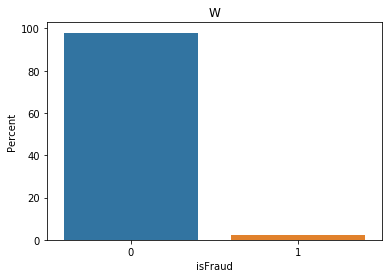

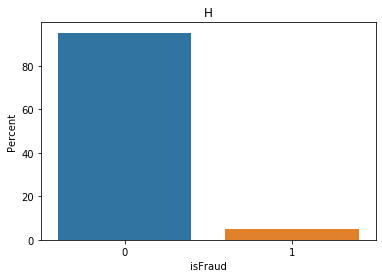

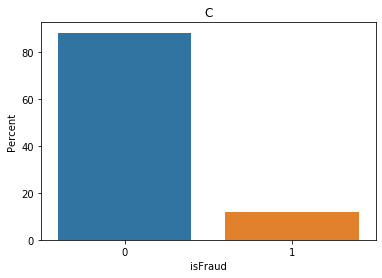

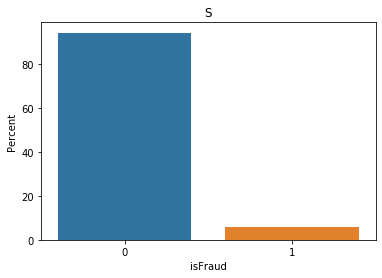

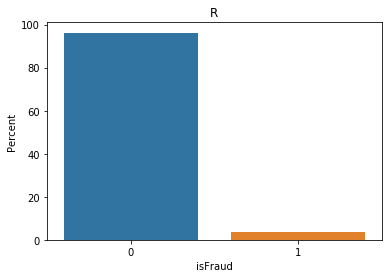

In [81]:
prodTypes = train_transaction_data['ProductCD'].unique()
for i,i_prod in enumerate(prodTypes):
    productData = eval('train_transaction_data.loc[train_transaction_data["ProductCD"]=="'+i_prod+'"]')
    plt.figure(i)
    ax = sns.barplot(x="isFraud", y="isFraud", data=productData, estimator=lambda x: len(x) / len(productData) * 100)
    ax.set(ylabel="Percent")
    ax.set_title(i_prod)

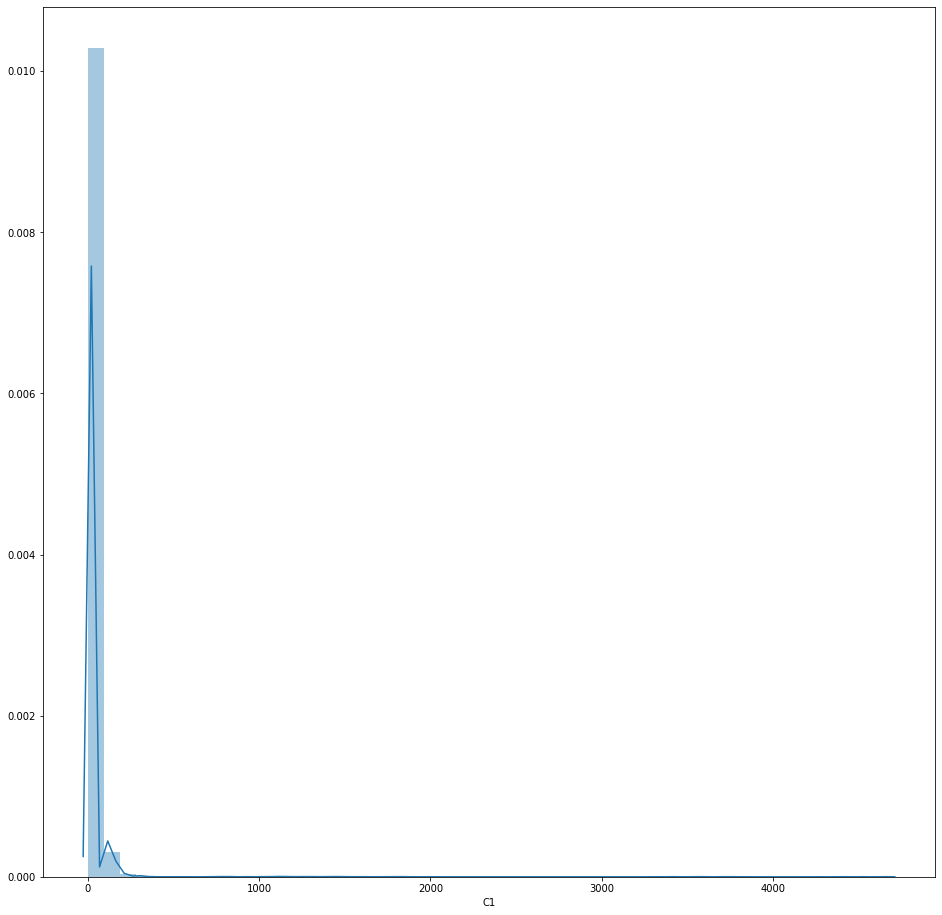

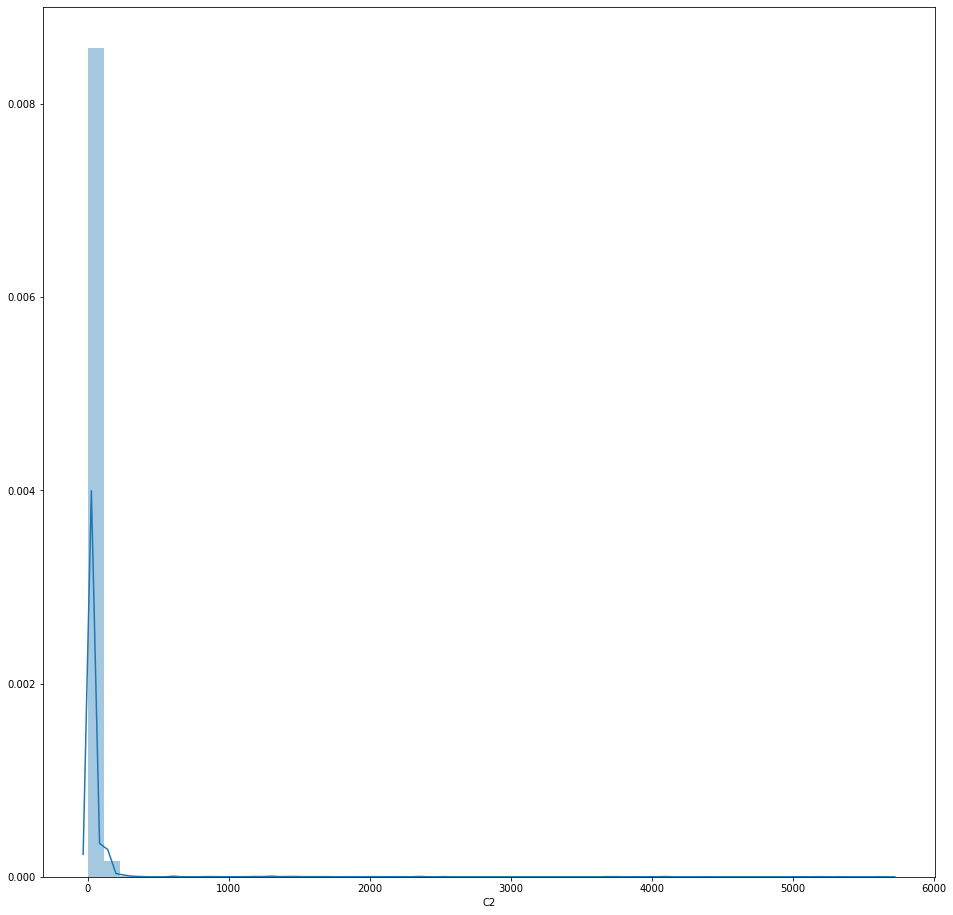

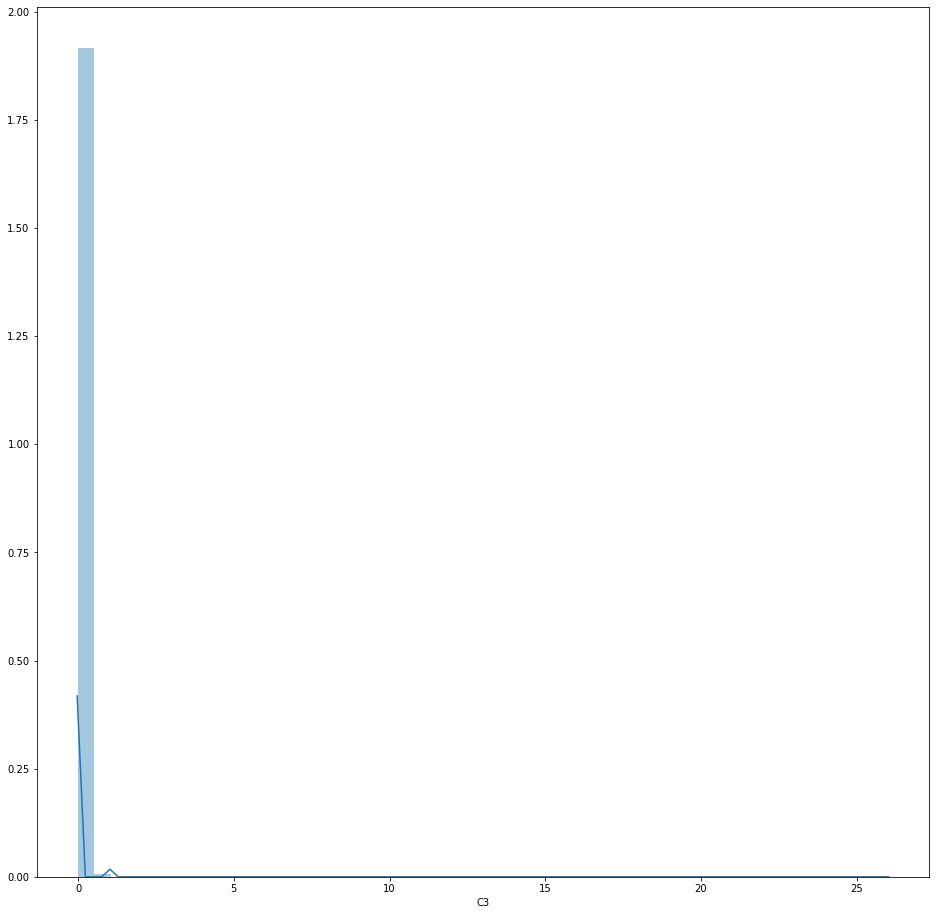

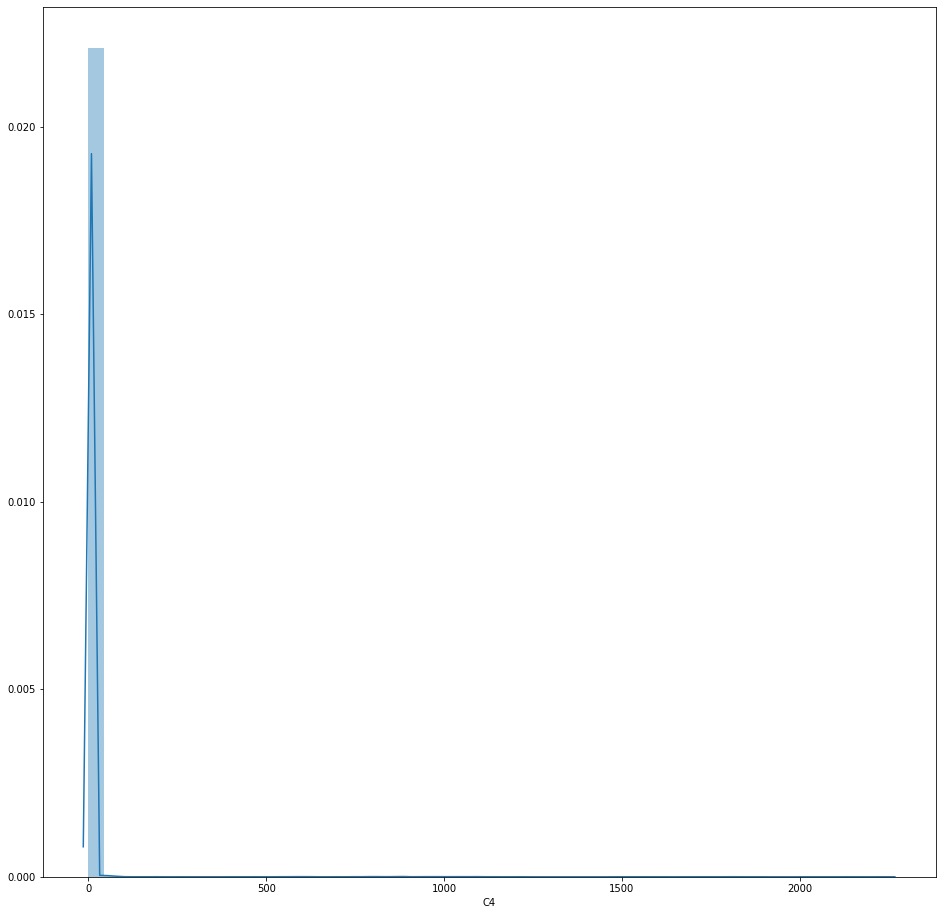

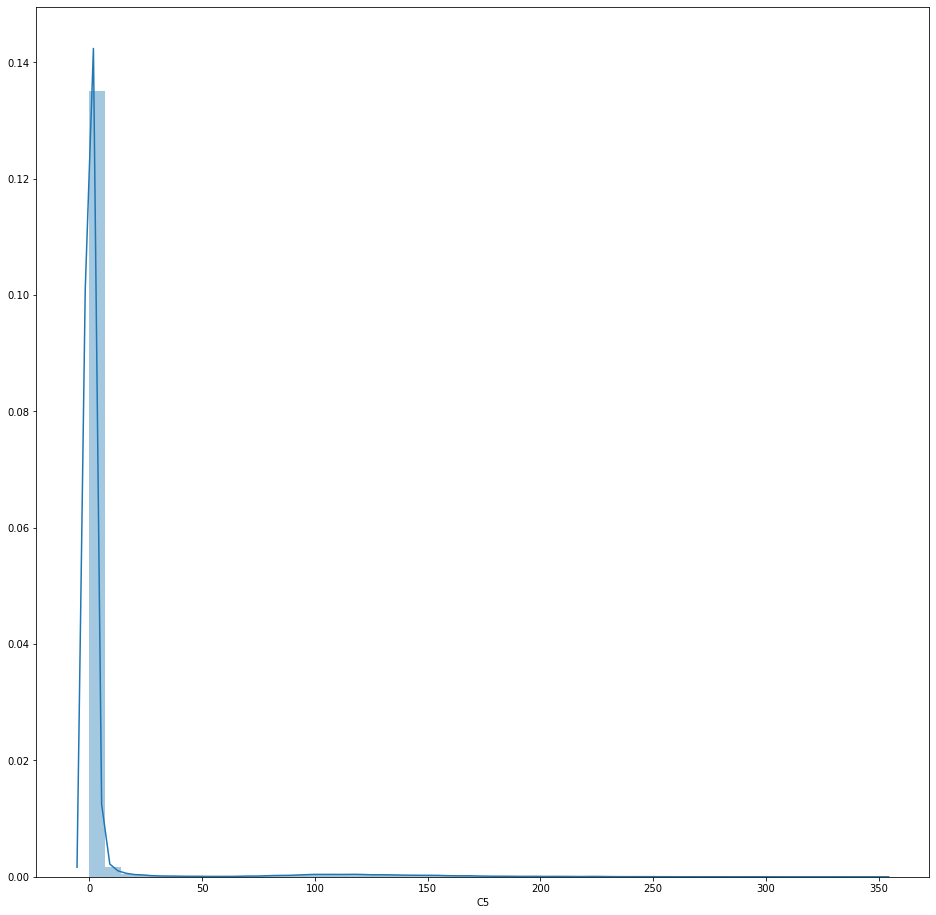

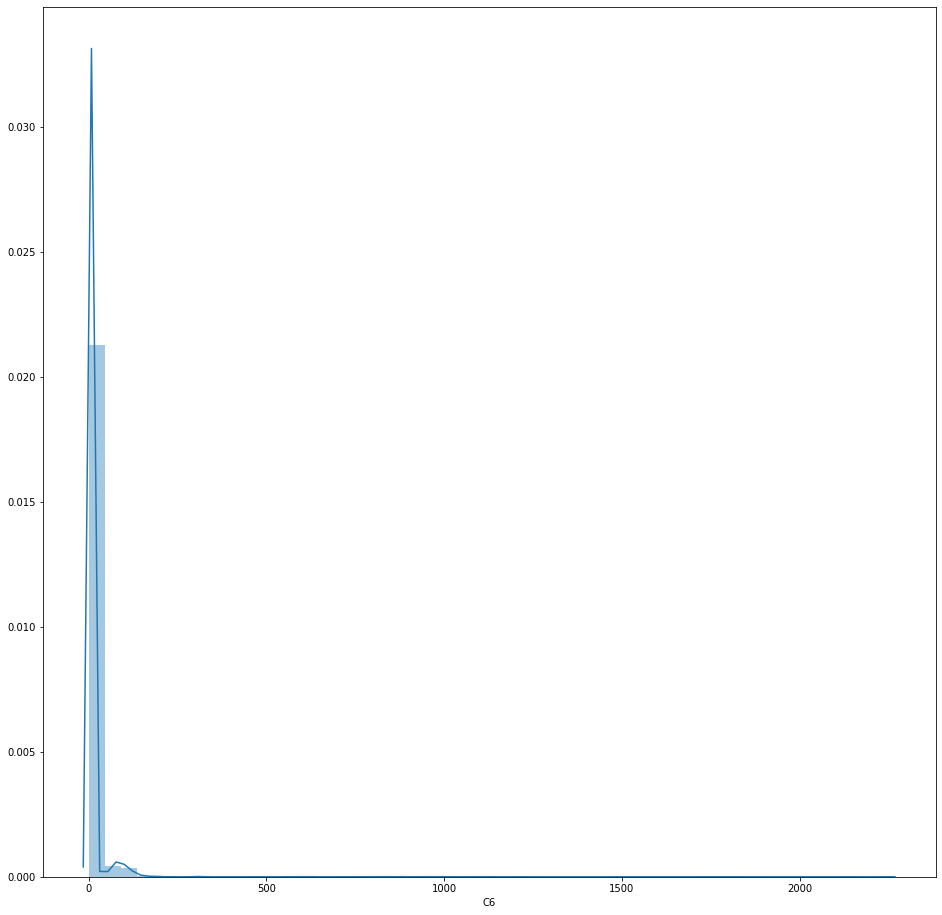

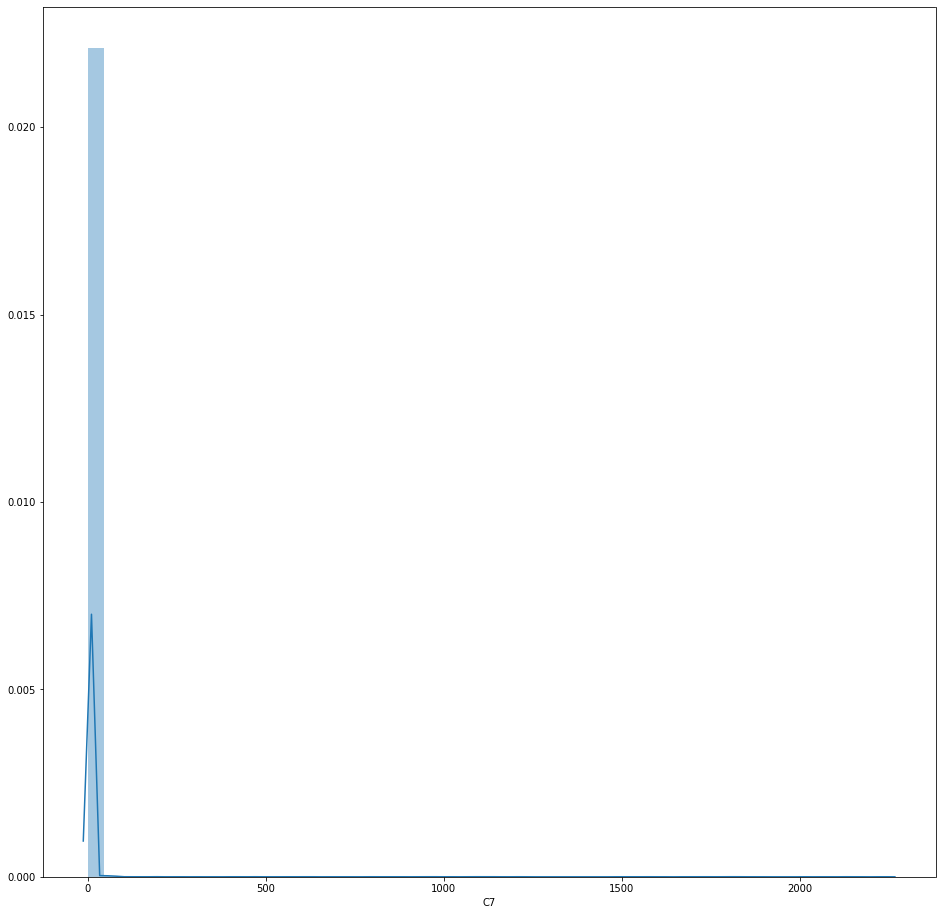

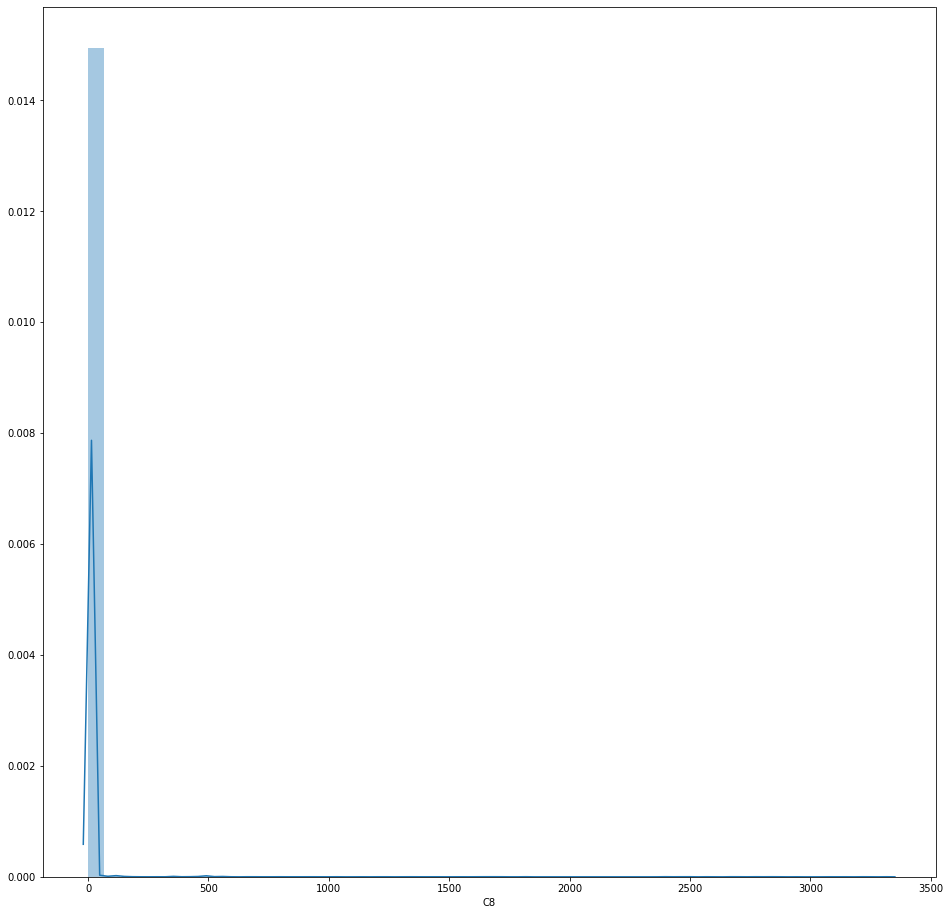

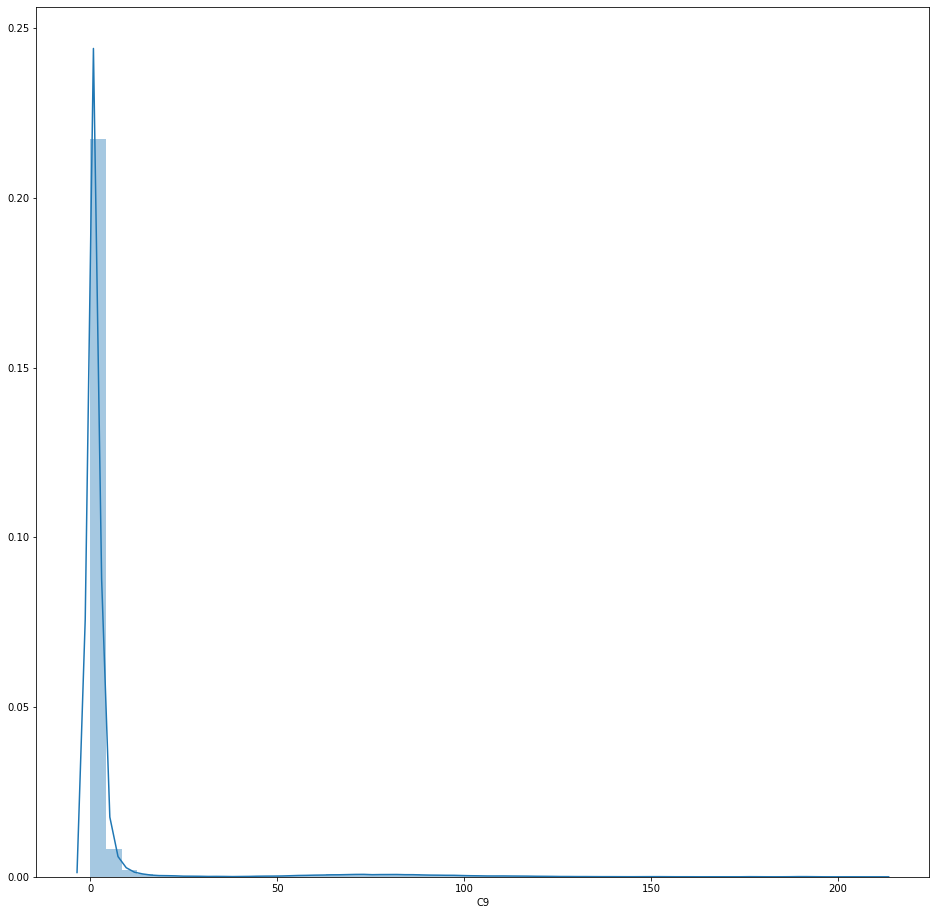

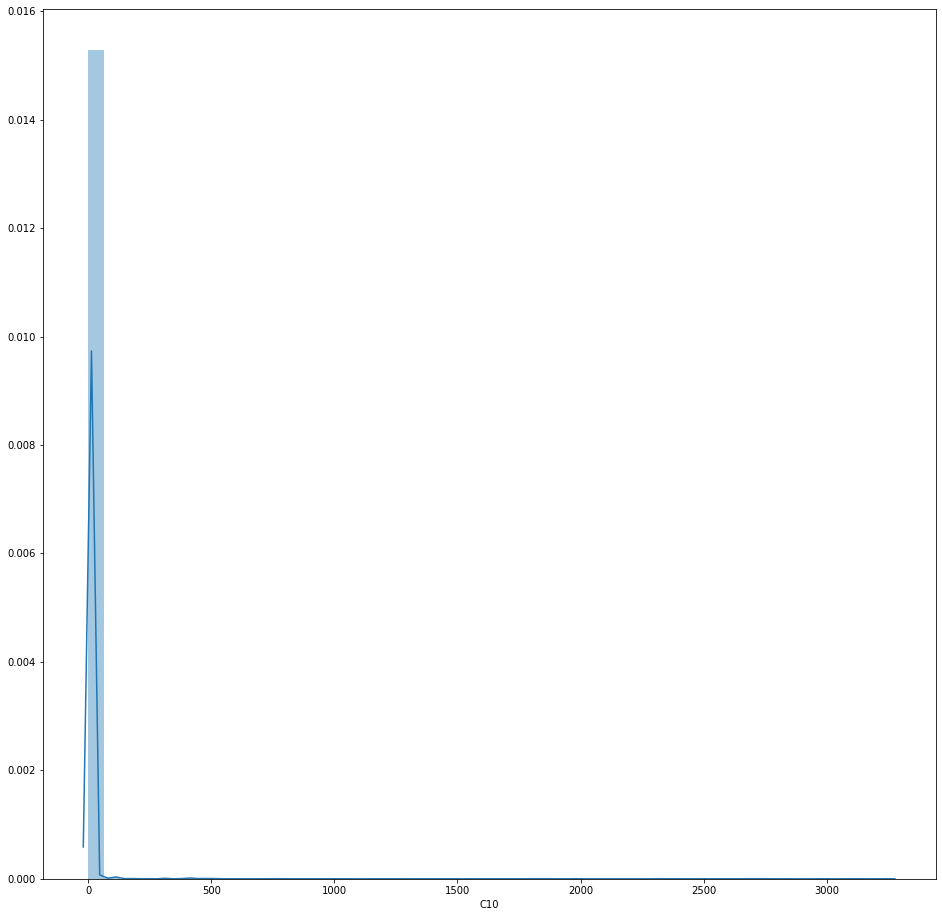

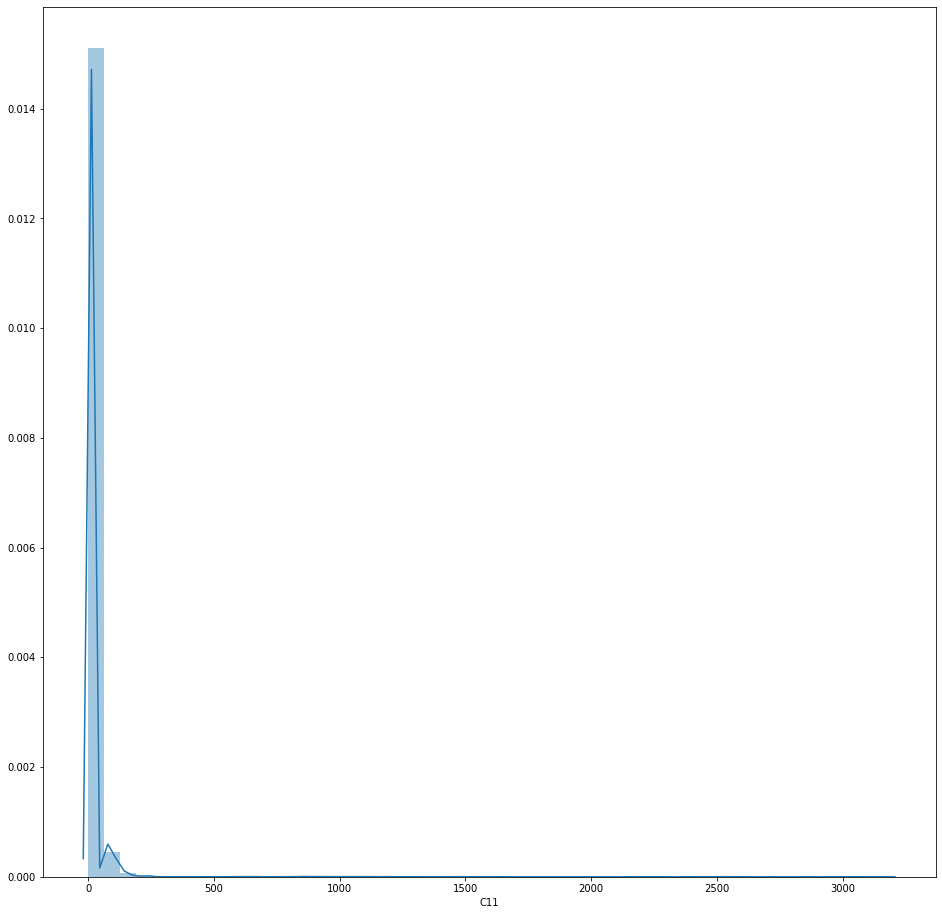

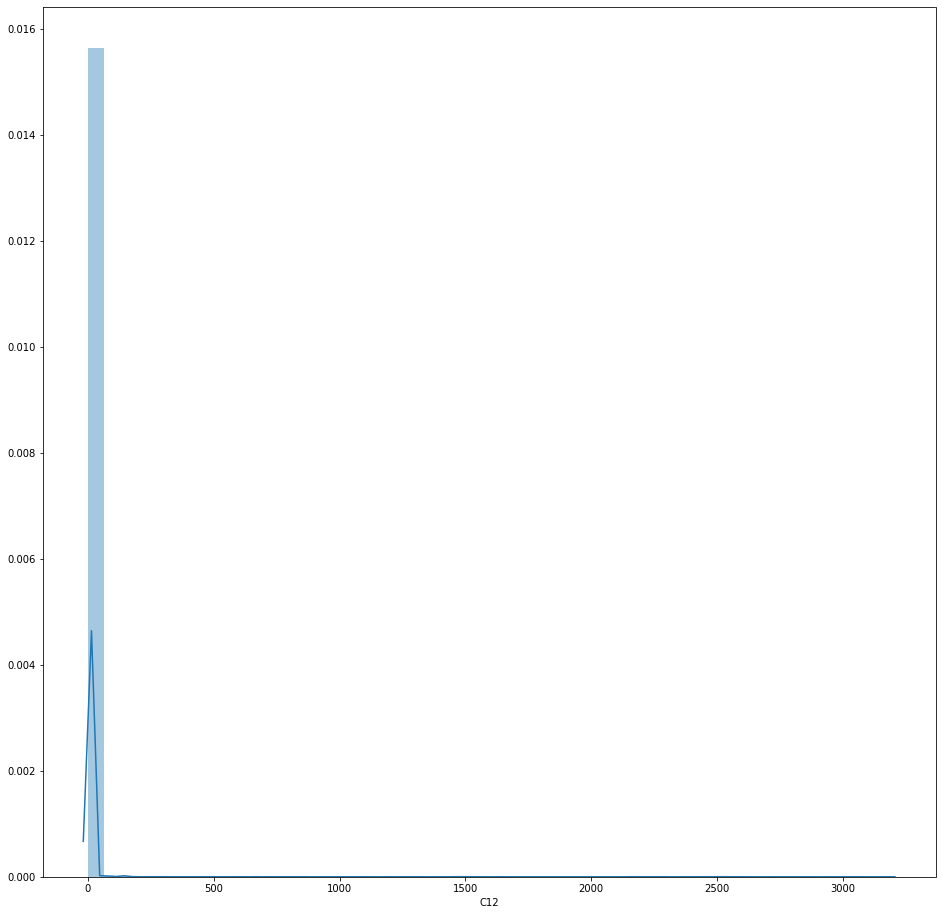

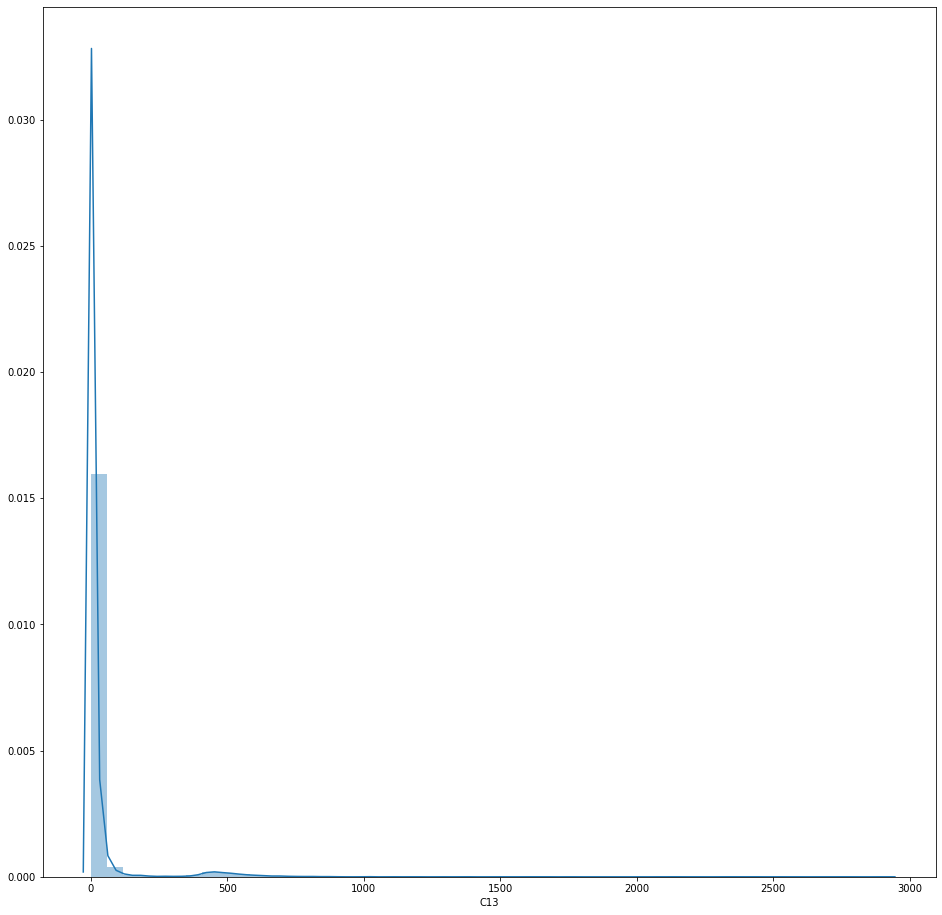

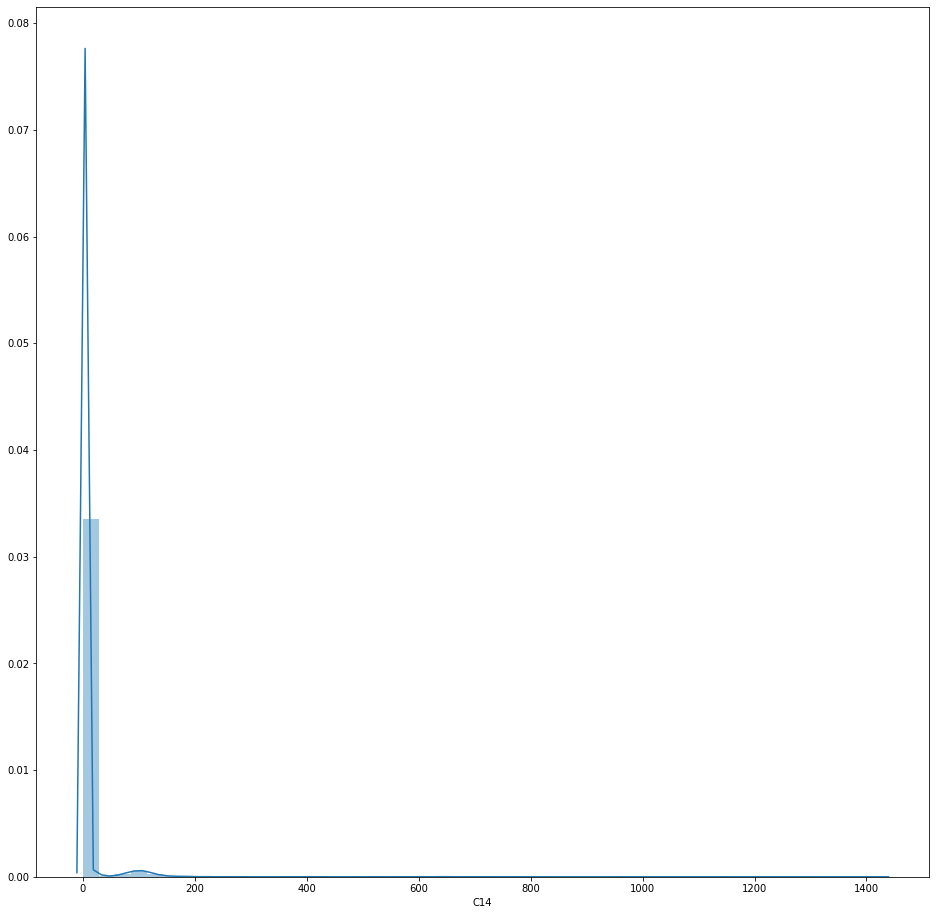

In [82]:
for i in range(1,15):    
    plt.figure(figsize=(16, 16))
    sns.distplot(eval('train_transaction_data["C'+str(i)+'"]'))
    ax.set(ylabel="Distribution")
    ax.set_title(['C'+str(i)])

In [84]:
print(train_identity_data.columns)

Index(['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
       'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14',
       'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
       'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object')


In [85]:
identity_data_columns = train_identity_data.columns
numericCols = train_identity_data._get_numeric_data().columns
categoricalCols = list(set(identity_data_columns) - set(numericCols))
print('The categorical columns in identity data are: ',categoricalCols)
train_identity_data[categoricalCols] = train_identity_data[categoricalCols].replace({ np.nan:'missing'})
train_identity_data[numericCols] = train_identity_data[numericCols].replace({ np.nan:-1})

The categorical columns in identity data are:  ['DeviceType', 'DeviceInfo', 'id_27', 'id_29', 'id_36', 'id_28', 'id_30', 'id_38', 'id_23', 'id_31', 'id_34', 'id_12', 'id_33', 'id_37', 'id_16', 'id_35', 'id_15']


In [87]:
np.unique(train_identity_data['id_30'])

array(['Android', 'Android 4.4.2', 'Android 5.0', 'Android 5.0.2',
       'Android 5.1.1', 'Android 6.0', 'Android 6.0.1', 'Android 7.0',
       'Android 7.1.1', 'Android 7.1.2', 'Android 8.0.0', 'Android 8.1.0',
       'Linux', 'Mac', 'Mac OS X 10.10', 'Mac OS X 10.11',
       'Mac OS X 10.12', 'Mac OS X 10.13', 'Mac OS X 10.6',
       'Mac OS X 10.9', 'Mac OS X 10_10_5', 'Mac OS X 10_11_3',
       'Mac OS X 10_11_4', 'Mac OS X 10_11_5', 'Mac OS X 10_11_6',
       'Mac OS X 10_12', 'Mac OS X 10_12_1', 'Mac OS X 10_12_2',
       'Mac OS X 10_12_3', 'Mac OS X 10_12_4', 'Mac OS X 10_12_5',
       'Mac OS X 10_12_6', 'Mac OS X 10_13_1', 'Mac OS X 10_13_2',
       'Mac OS X 10_13_3', 'Mac OS X 10_13_4', 'Mac OS X 10_13_5',
       'Mac OS X 10_6_8', 'Mac OS X 10_7_5', 'Mac OS X 10_8_5',
       'Mac OS X 10_9_5', 'Windows', 'Windows 10', 'Windows 7',
       'Windows 8', 'Windows 8.1', 'Windows Vista', 'Windows XP', 'func',
       'iOS', 'iOS 10.0.2', 'iOS 10.1.1', 'iOS 10.2.0', 'iOS 10.2.1',

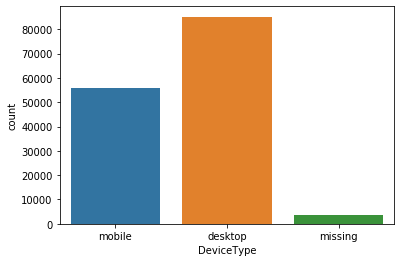

In [88]:
sns.countplot(train_identity_data['DeviceType'])

In [93]:
# Combining both datasets
df_dataset = train_transaction_data.merge(train_identity_data, how='outer', on='TransactionID')
print(train_transaction_data.shape)
print(df_dataset.shape)

(590540, 396)
(590540, 436)


In [92]:
df_dataset.sample(20)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,Transaction_dow,Transaction_hour,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
426394,3413394,0,10782389,49.000,W,10057,225.0,150.0,mastercard,224.0,debit,269.0,87.0,-1.0,-1.0,yahoo.com,missing,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,-1.0,-1.0,383.0,383.0,-1.0,-1.0,-1.000000,-1.000000,0.0,383.0,-1.0,-1.0,-1.0,383.0,T,T,T,M0,F,F,F,T,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000,0.000,0.000,0.000000,0.000000,0.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.

In [95]:
#print total number of NANs in the dataset
print('Total Number of NANs = ', df_dataset.isnull().sum().sum())

Total Number of NANs =  17852280


In [96]:
# In all the numerical fields we can see the data does not surpase -600 so we can patch NAN with -999
df_dataset.fillna(value=-999, inplace=True)

In [97]:
print('Total Number of NANs = ', df_dataset.isnull().sum().sum())

Total Number of NANs =  0


In [103]:
print(f'Total number of Transactions {df_dataset.shape[0]}')
print(f'Total Number of Fraudulent Transactions {df_dataset["isFraud"].values.sum()}')
print(f'Just {(df_dataset["isFraud"].values.sum()/df_dataset.shape[0])*100:0.3f}% of the transactions are Fraudulent')

Total number of Transactions 590540
Total Number of Fraudulent Transactions 20663
Just 3.499% of the transactions are Fraudulent


Only 3.5 percent of transactions are Fraudulent due to an imbalanced dataset. So lets balance out the dataset

In [104]:
# Separate the target column, isFraud
y = df_dataset['isFraud']
# Drop the isFraud column from the dataset df
X = df_dataset.drop(labels='isFraud', axis=1)

print(y.shape, X.shape)
display(y.sample(5))
display(X.sample(5))

(590540,) (590540, 435)


414335    0
317323    0
449421    0
182133    0
559806    0
Name: isFraud, dtype: int64

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,Transaction_dow,Transaction_hour,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
390423,3377423,9809341,49.00,W,7377,555.0,150.0,mastercard,117.0,debit,204.0,87.0,-1.0,-1.0,yahoo.com,missing,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,0.0,0.0,-1.0,-1.0,-1.0,0.0,T,T,T,M0,F,F,F,F,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,12.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.

In [105]:
# Clear RAM 
df_dataset = None

In [106]:
# Now that we have separated the target variable
# Time to undersample 
rus = RandomUnderSampler(random_state=786)
X_rus, y_rus = rus.fit_resample(X, y)

# Check
print(X_rus.shape, y_rus.shape)

NameError: name 'RandomUnderSampler' is not defined